# Classification task

In [385]:
import pandas as pd
import os
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from imblearn.over_sampling import RandomOverSampler, ADASYN
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import time
from sklearn.externals import joblib

**Step 1:** Let's load our dataset that is in data folder

In [383]:
def read_data(dataset):
    os.chdir(".\\data")
    df = pd.read_csv(dataset)
    os.chdir(".\\..")
    return df
df = read_data("data.csv")
print(df.describe())

       BUYING  MAINT DOORS PERSONS BUG_BOOT SAFETY  CLASS
count    1728   1728  1728    1728     1728   1728   1728
unique      4      4     4       3        3      3      4
top     vhigh  vhigh     2       2      big    low  unacc
freq      432    432   432     576      576    576   1210


**Step 2:** We see that the dataset is pretty small with small number of unique values of each feature. Let's see the unique values of each feature

In [275]:
def print_unique(df):
    print ("Unique value for each features are:\n")
    for col in df:
        print(col+" : "+str(df[col].unique()))
print_unique(df)

Unique value for each features are:

BUYING : [4 3 2 1]
MAINT : [4 3 2 1]
DOORS : [2 3 4 5]
PERSONS : [2 4 5]
BUG_BOOT : [1 2 3]
SAFETY : [1 2 3]
CLASS : ['unacc' 'acc' 'vgood' 'good']


**Step 3:** All of the values can be transformed to ordinals. Moreover, BUYING, MAINT and SAFETY share the same dictionary. Let's process feature's values by transforming strings into ordinals

In [101]:
def process_categories(df):
    buying = {'low': 1, 'med': 2, 'high': 3, 'vhigh': 4}
    bug_boot = {'small': 1, 'med': 2, 'big': 3}
    df.BUYING = [buying[item] for item in df.BUYING]
    df.MAINT = [buying[item] for item in df.MAINT]
    df.loc[df.DOORS == '5more', 'DOORS'] = 5
    df.loc[df.PERSONS == 'more', 'PERSONS'] = 5
    df.BUG_BOOT = [bug_boot[item] for item in df.BUG_BOOT]
    df.SAFETY = [buying[item] for item in df.SAFETY]
    df[df.columns[:-1]] = df[df.columns[:-1]].astype('int64')
    return df
df = process_categories(df)
print_unique(df)


Unique value for each features are:
BUYING : [4 3 2 1]
MAINT : [4 3 2 1]
DOORS : [2 3 4 5]
PERSONS : [2 4 5]
BUG_BOOT : [1 2 3]
SAFETY : [1 2 3]
CLASS : ['unacc' 'acc' 'vgood' 'good']


**Histogram building:** Let's build histograms that show the number of occurencies of ordinals in each class

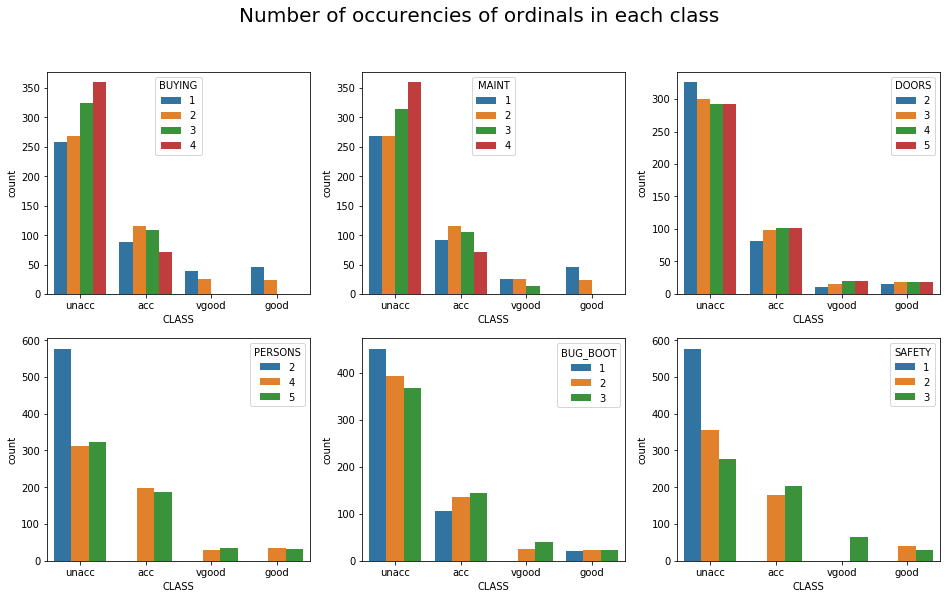

In [277]:
fig, ax = plt.subplots(figsize=(16,9), ncols=3, nrows=2)
plt.suptitle("Number of occurencies of ordinals in each class", fontsize=20)

for col, elem in zip(df.columns[:-1], ax.flat):
    sns.countplot(x="CLASS", hue=col, data=df, ax=elem)

**Analysys and Algorythm choosing:** We see that many ordinal's values have zero occurencies in some classes. We also see that in most of the cases values of ordinals are quite uniformely spread in each class. That means each occurence of certain value is unlikely to be noise. That means we can choose algorythms that are sensitive to the occurence and absense of values in each class. Since our dataset is small our algorythm shouldn't have high comlexity, because there's a risk of overfitting. And also since our data are all ordinals, linear models aren't applicable here, because we can't be sure in distances beetween values. Additionaly, few number of features isn't favourable for linear models. Paying attention to all the above facts, we should choose tree-based model. Especially good choice is RandomForest. It's not linear, good with ordinals and small datasets and sensitive to occurencies of values. 

## Training and tuning

**Step 1: dataset splitting.** First let's split our dataset into features and target. Then we'll split our dataset into train and test sets with ratio of 70% : 30%. Since our dataset is small we want as many data as possible for training. We also need enough data for testing not to be biased.  

In [259]:
def split_data(df):
    X = df[df.columns[:-1]]
    y = df.CLASS
    return X, y
    
def split_train_test(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
    
    return X_train, X_test, y_train, y_test
    
X, y = split_data(df) 
X_train, X_test, y_train, y_test = split_train_test(X, y)


In [326]:
def evaluate_model(model, x_train, y_train, x_test, y_test):
    n_trees = model.get_params()['n_estimators']
    max_features = model.get_params()['max_features']
    max_depth = model.get_params()['max_depth']
    min_samples_split = model.get_params()['min_samples_split']
    

    run_times = []
    for _ in range(10):
        start_time = time.time()
        model.fit(x_train, y_train)
            
        end_time = time.time()
        run_times.append(end_time - start_time)
    
    # Run time and predictions need to be averaged
    run_time = np.mean(run_times)
        
    # Calculate performance metrics
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    f1_score_macro = f1_score(y_test, y_pred, average='macro')
    
    # Return results in a dictionary
    results = {'time': run_time, 'accuracy': accuracy, 'f1_score_macro': f1_score_macro, 'n_trees': n_trees, 'max_features': max_features,
              'max_depth': max_depth, 'min_samples_split': min_samples_split}
    
    return results

**Step 2:** Let's give first try to RandomForest model

In [327]:
clf = RandomForestClassifier(random_state=2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

base_result = evaluate_model(clf, X_train, y_train, X_test, y_test)
base_result['model'] = 'base_model'
def print_result(name):
    print('\n'+name+" accuracy: " + str(accuracy_score(y_test, y_pred)))
    print(classification_report(y_test, y_pred, digits=4))
    print("f1-score macro: "+str(f1_score(y_test, y_pred, average='macro')))

print_result('Base model')



Base model accuracy: 0.9624277456647399
             precision    recall  f1-score   support

        acc     0.9101    0.9759    0.9419        83
       good     0.9000    0.6923    0.7826        13
      unacc     0.9916    0.9793    0.9854       241
      vgood     0.7778    0.7778    0.7778         9

avg / total     0.9630    0.9624    0.9619       346

f1-score macro: 0.8719082899601485


**Step3: Oversampling.** Overall accuracy is quite good, but our dataset is imbalanced, so f1-score for small class classes is low. It results in low f1 macro score, which is unweighted in relation to the classes. Let's try random oversampling

In [329]:
clf = RandomForestClassifier(random_state=2)
X_resampled, y_resampled = RandomOverSampler().fit_sample(X_train, y_train)
clf.fit(X_resampled, y_resampled)
y_pred = clf.predict(X_test)

random_oversampling = evaluate_model(clf, X_train, y_train, X_test, y_test)
random_oversampling['model'] = 'random_oversampling'

print_result('Oversampled Random')


Oversampled Random accuracy: 0.976878612716763
             precision    recall  f1-score   support

        acc     0.9326    1.0000    0.9651        83
       good     0.9167    0.8462    0.8800        13
      unacc     1.0000    0.9834    0.9916       241
      vgood     0.8750    0.7778    0.8235         9

avg / total     0.9774    0.9769    0.9767       346

f1-score macro: 0.9150693724994133


**ADASYN Oversampling with rounding:** Let's try more elaborate technic ADASYN for oversampling. Since our values are ordinals, we'll round oversampled values and make sure unique values of oversampled trainset remained the same

In [330]:
clf = RandomForestClassifier(random_state=3)
X_resampled, y_resampled = ADASYN().fit_sample(X_train, y_train)
X_resampled = np.round(X_resampled)
print_unique(df)
print("\nUnique features for oversampled ADASYN trainset with rounding:")
for i in range(6):
    print(np.unique(X_resampled[:,i]))
clf.fit(X_resampled, y_resampled)
y_pred = clf.predict(X_test)

adasyn_oversampling = evaluate_model(clf, X_train, y_train, X_test, y_test)
adasyn_oversampling['model'] = 'adasyn_oversampling'


print_result('Oversampled ADASYN')

Unique value for each features are:

BUYING : [4 3 2 1]
MAINT : [4 3 2 1]
DOORS : [2 3 4 5]
PERSONS : [2 4 5]
BUG_BOOT : [1 2 3]
SAFETY : [1 2 3]
CLASS : ['unacc' 'acc' 'vgood' 'good']

Unique features for oversampled ADASYN trainset with rounding:
[1. 2. 3. 4.]
[1. 2. 3. 4.]
[2. 3. 4. 5.]
[2. 4. 5.]
[1. 2. 3.]
[1. 2. 3.]

Oversampled ADASYN accuracy: 0.976878612716763
             precision    recall  f1-score   support

        acc     0.9535    0.9880    0.9704        83
       good     0.9167    0.8462    0.8800        13
      unacc     0.9958    0.9876    0.9917       241
      vgood     0.7778    0.7778    0.7778         9

avg / total     0.9770    0.9769    0.9768       346

f1-score macro: 0.9049646614069691



**Step 4: Tuning.** In order to tune hyperparameters we won't iterate on testset. We'll use k-fold cross-validation technic. First let's use RandomizedSearchCV to narrow the search

In [289]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(7, 100, num = 10)]
max_depth.append(None)
min_samples_split = [2, 6, 12]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
criterion = ['gini', 'entropy']
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}
clf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid,
                               n_iter = 100, cv = 4, verbose=5, random_state=12, n_jobs = -1)

**Searching for the best model:** After setting reasonable ranges for hyperparameters let's search for the best model

In [294]:
rf_random.fit(X_resampled, y_resampled)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 11.4min finished


RandomizedSearchCV(cv=4, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [7, 17, 27, 38, 48, 58, 69, 79, 89, 100, None], 'min_samples_split': [2, 6, 12], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=12, refit=True,
      

**Accuracy for best parameters:** Let's examine best parameters and accuracy for this model

In [376]:
print('Best parameters are: ')
print(rf_random.best_params_)
best_random = rf_random.best_estimator_
y_pred = best_random.predict(X_test)

randomsearch_best = evaluate_model(best_random, X_train, y_train, X_test, y_test)
randomsearch_best['model'] = 'best_random'

print_result('Best Randomized search model')

Best parameters are: 
{'n_estimators': 1700, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100, 'criterion': 'entropy', 'bootstrap': False}

Best Randomized search model accuracy: 0.9797687861271677
             precision    recall  f1-score   support

        acc     0.9647    0.9880    0.9762        83
       good     0.9167    0.8462    0.8800        13
      unacc     0.9958    0.9917    0.9938       241
      vgood     0.7778    0.7778    0.7778         9

avg / total     0.9797    0.9798    0.9797       346

f1-score macro: 0.9069328119328119


**Grid search for best model searching:** Now that we've narrowed the range let's use Grid Search to find the best model with distinct values for hyperparameters:

In [304]:
param_grid = {
    'bootstrap': [False],
    'max_depth': [20, 25, 27, 35],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 4, 6],
    'n_estimators': [700, 1100, 1200],
    'criterion': ['gini']
}

clf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                          cv = 4, n_jobs = -1, verbose = 5)
grid_search.fit(X_resampled, y_resampled)


Fitting 4 folds for each of 216 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 24.0min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [False], 'max_depth': [20, 25, 27, 35], 'max_features': [2, 3], 'min_samples_leaf': [1, 2, 3], 'min_samples_split': [2, 4, 6], 'n_estimators': [700, 1100, 1200], 'criterion': ['gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

**Estimation of the result for Grid search:** Let's estimate the result for the best model

In [348]:
best_grid = grid_search.best_estimator_
print('Best parameters are: ')
print(grid_search.best_params_)
y_pred = best_grid.predict(X_test)
print_result('Best Grid model')
grid_best = evaluate_model(best_grid, X_train, y_train, X_test, y_test)
grid_best['model'] = 'best_grid'


Best parameters are: 
{'bootstrap': False, 'criterion': 'gini', 'max_depth': 27, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 700}

Best Grid model accuracy: 0.9826589595375722
             precision    recall  f1-score   support

        acc     0.9647    0.9880    0.9762        83
       good     1.0000    0.8462    0.9167        13
      unacc     0.9959    0.9959    0.9959       241
      vgood     0.7778    0.7778    0.7778         9

avg / total     0.9829    0.9827    0.9825       346

f1-score macro: 0.9166213857603899


**Estimation:** We achived slight improvement in comparison to the previous model. Let's see if we can improve further by new Grid search with different values for hyperparameters

In [343]:
param_grid = {
    'bootstrap': [False],
    'max_depth': [25, 27, 28, 30],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 4],
    'n_estimators': [400, 500, 700, 1000],
    'criterion': ['gini']
}

clf = RandomForestClassifier()
grid_search_2 = GridSearchCV(estimator = clf, param_grid = param_grid, 
                          cv = 4, n_jobs = -1, verbose = 5)
grid_search_2.fit(X_resampled, y_resampled)


Fitting 4 folds for each of 128 candidates, totalling 512 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:  8.6min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [False], 'max_depth': [25, 27, 28, 30], 'max_features': [2, 3], 'min_samples_leaf': [1, 2], 'min_samples_split': [2, 4], 'n_estimators': [400, 500, 700, 1000], 'criterion': ['gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [387]:
best_grid = grid_search_2.best_estimator_
print('Best parameters are: ')
print(grid_search.best_params_)
y_pred = best_grid.predict(X_test)
grid_best_final = best_grid 
grid_best_final = evaluate_model(best_grid, X_train, y_train, X_test, y_test)
grid_best_final['model'] = 'grid_best_final'
print_result('Best Grid2 model')
print('The model is saved as best_model.pkl')
joblib.dump(best_grid, 'best_model.pkl')

Best parameters are: 
{'bootstrap': False, 'criterion': 'gini', 'max_depth': 27, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 700}

Best Grid2 model accuracy: 0.9826589595375722
             precision    recall  f1-score   support

        acc     0.9647    0.9880    0.9762        83
       good     1.0000    0.8462    0.9167        13
      unacc     0.9959    0.9959    0.9959       241
      vgood     0.7778    0.7778    0.7778         9

avg / total     0.9829    0.9827    0.9825       346

f1-score macro: 0.9166213857603899
The model is saved as best_model.pkl


['best_model.pkl']

**Estimation of the second GridSearch:** We achived no impovment in the accuracy, but the last model uses less number of estimators, which makes it quicker. As we can no longer achieve improvement in accuracy it's resonable to treat this model as the final one. This model is saved in file as best_model.pkl

## Comparison of the models and final remarks

**Comparison:** Let's compare all built models

In [379]:
comparison = {'model': [base_result['model'], random_oversampling['model']],
              'accuracy': [round(base_result['accuracy'], 3), round(random_oversampling['accuracy'], 3)],
              'f1_score_macro': [round(base_result['f1_score_macro'], 3), round(random_oversampling['f1_score_macro'], 3)],
              'max_features': [base_result['max_features'], random_oversampling['max_features']],
              'n_trees': [base_result['n_trees'], int(random_oversampling['n_trees'])],
              'time': [round(base_result['time'], 4), round(random_oversampling['time'], 4)],
              'max_depth': [base_result['max_depth'], random_oversampling['max_depth']],
              'min_samples_split': [base_result['min_samples_split'], random_oversampling['min_samples_split']]}

for model in [adasyn_oversampling, randomsearch_best, grid_best, grid_best_final]:
    comparison['accuracy'].append(round(model['accuracy'], 3))
    comparison['f1_score_macro'].append(round(model['f1_score_macro'], 3))
    comparison['model'].append(model['model'])
    comparison['max_features'].append(model['max_features'])
    comparison['n_trees'].append(int(model['n_trees']))
    comparison['time'].append(round(model['time'], 4))
    comparison['max_depth'].append(model['max_depth'])
    comparison['min_samples_split'].append(model['min_samples_split'])
    
comparison = pd.DataFrame.from_dict(comparison, orient = 'columns')
comparison[['model', 'accuracy', 'f1_score_macro', 'max_features', 'n_trees', 'time', 'max_depth',
           'min_samples_split']]



,model,accuracy,f1_score_macro,max_features,n_trees,time,max_depth,min_samples_split
0,base_model,0.962,0.872,auto,10,0.0262,NaN,2
1,random_oversampling,0.962,0.872,auto,10,0.0251,NaN,2
2,adasyn_oversampling,0.974,0.913,auto,10,0.0234,NaN,2
3,best_random,0.980,0.907,sqrt,1700,5.0471,100.0,2
4,best_grid,0.983,0.917,2,700,1.7814,27.0,2
5,grid_best_final,0.983,0.917,2,500,1.2088,30.0,2


**Conclusion:** 
We see that the final model, although slower than base model, improved not only in accuracy, but also in f1 macro score. That means it performs better for small classes. We achived that by first using random oversampling for smaller classes, than ADASYN oversampling with rounding. That's how we dealt with unbalanced classes problem. In tuning, we used k-fold cross-validation. Firstly, we used Random Search to narrow the range of hyperparameters values. Than we used Grid search two times with different hyperparameters values. The final model isn't better in accuracy than the previous one, but it's quicker. We achieved this by finding optimal number of estimators. 

**Final remarks about dataset:** Our dataset was specific in being relativly small, it contained only ordinal features and it had unbalanced classes. Firstly, we transformed string values to ordinals. Than we analysed dataset and came to the conclusion that RandomForest is the best algorithm for the task.

**Final remarks about the best model:** The best model is saved as best_model.pkl in root folder